In [1]:
import torch
import numpy as np 
import matplotlib.pyplot as plt
import spatial_maps as sm
import scipy

from tqdm import tqdm
from models import FFGC, RNNGC
from plotting_functions import *
from dataset import DatasetMaker

## RNN

In [2]:
## Training parameters
train_steps = 50000
timesteps = 10
bs = 64 # batch size

# Model parameters
ng = 256 # no. of recurrent units
alpha = 0.88

In [3]:
# instantiate RNN model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = RNNGC(ng = ng, alpha = alpha)
model = model.load("./best_models/RNNGC.pkl")

model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

c:\Users\kingt\anaconda3\envs\torch2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def jitter(nsamples, magnitudes=None, magnitude=1e-2, epsilon=1e-8):
    """
    Parameters:
        nsamples int: size of jitter vector
        magnitudes (nsamples,): ndarray of optional jitter magnitudes
        magnitude float: magnitude range to sample

    Return:
        v_jitter (nsamples,2): The jitter vectors
    """
    thetas = torch.rand(size=(nsamples,)) * 2 * np.pi
    if magnitudes is None:
        magnitudes = torch.rand(size=(nsamples,)) * magnitude + epsilon
    v_jitter = torch.stack([torch.cos(thetas), torch.sin(thetas)], axis=-1)
    v_jitter = magnitudes[:, None] * v_jitter.to(device)
    return v_jitter, magnitudes

In [5]:
timesteps = 5
dataset = DatasetMaker()
rt, vt = dataset.generate_data(128, timesteps)

y_raw = model((rt[:,0], vt))
r_mag = torch.norm(vt[:,-1,:],dim=-1).squeeze().to(device)
dr1, magnitudes_space = jitter(y_raw.shape[0], magnitudes=r_mag)
dr2, _ = jitter(y_raw.shape[0], magnitudes=magnitudes_space)
# Unsqueeze as it needs the timestep dimension
dr1.unsqueeze_(1)
dr2.unsqueeze_(1)
# Stack the jitter vectors to the velocity vector vt
vt1 = torch.cat((vt, dr1), dim=1)
vt2 = torch.cat((vt, dr2), dim=1)

f1 = model((rt[:,0], vt1))
f = f1[:,-2,:]
f1 = f1[:,-1,:]
f2 = model((rt[:,0], vt2))
ff = f2[:,-2,:]
f2 = f2[:,-1,:]
rescale_r1 = torch.sum(dr1**2, axis=-1)
s1 =  2 * torch.sum((f - f1) ** 2, axis=-1) / torch.sum(rescale_r1, axis=-1)
rescale_r2 = torch.sum(dr2**2, axis=-1)
s2 =  2 * torch.sum((f - f2) ** 2, axis=-1) / torch.sum(rescale_r2, axis=-1)
conf_iso_loss = torch.mean((s1 - s2) ** 2)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [ ]:
def CI(model, rt0, vt, mean = True):
    r_mag = torch.linalg.norm(vt[:,-1,:],dim=-1).squeeze().to(device)
    dr1, _ = jitter(vt.shape[0], magnitudes=r_mag)
    dr2, _ = jitter(vt.shape[0], r_mag)
    dr1.unsqueeze_(1)
    dr2.unsqueeze_(1)
    vt1 = torch.cat((vt, dr1), dim=1)
    vt2 = torch.cat((vt, dr2), dim=1)

    with torch.inference_mode():
        f1 = model((rt0, vt1))
        f2 = model((rt0, vt2))[:,-1]
        f = f1[:,-2]
        f1 = f1[:,-1]
        
    rescale_r1 = torch.sum(dr1**2, axis=-1)
    s1 =  torch.sum((f - f1) ** 2, axis=-1) / torch.maximum(torch.sum(rescale_r1, axis=-1), torch.tensor(1e-14).to(device))
    rescale_r2 = torch.sum(dr2**2, axis=-1)
    s2 =  torch.sum((f - f2) ** 2, axis=-1) / torch.maximum(torch.sum(rescale_r2, axis=-1), torch.tensor(1e-14).to(device))

    if mean:
        conf_iso_loss = torch.mean((s1 - s2) ** 2)
        return conf_iso_loss
    conf_iso_loss = (s1 - s2) ** 2
    return conf_iso_loss



In [ ]:
timesteps = 10
r, v = dataset.generate_data(50000, timesteps, device)
CIs = []
for i in range(1,timesteps):
    CIs.append(CI(model, r[:,0], v[:,:i], mean = False))
CIs = torch.stack(CIs)

# Ratemaps
ratemaps = np.array([scipy.stats.binned_statistic_2d(r[:,i,0].cpu().numpy(), r[:,i,1].cpu().numpy(), CIs[i].cpu().numpy(), bins=64, statistic='mean')[0] for i in range(timesteps - 1)])
ratemaps_mean = scipy.stats.binned_statistic_2d(r[:,0,0].cpu().numpy(), r[:,0,1].cpu().numpy(), CIs.mean(dim=0).cpu().numpy(), bins=64, statistic='mean')[0]


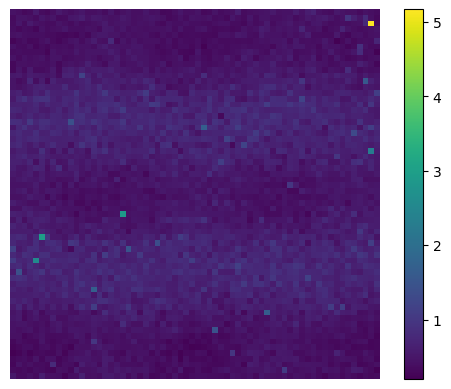

In [ ]:
plt.imshow(ratemaps_mean, extent=[-1, 1, -1, 1], origin='lower')#, vmin=0, vmax=1.2)
plt.axis("off")
plt.colorbar()
plt.show()

In [ ]:
r.shape, r[:,0, 0].shape, CIs.T.shape, 

(torch.Size([50000, 10, 2]), torch.Size([50000]), torch.Size([50000, 9]))

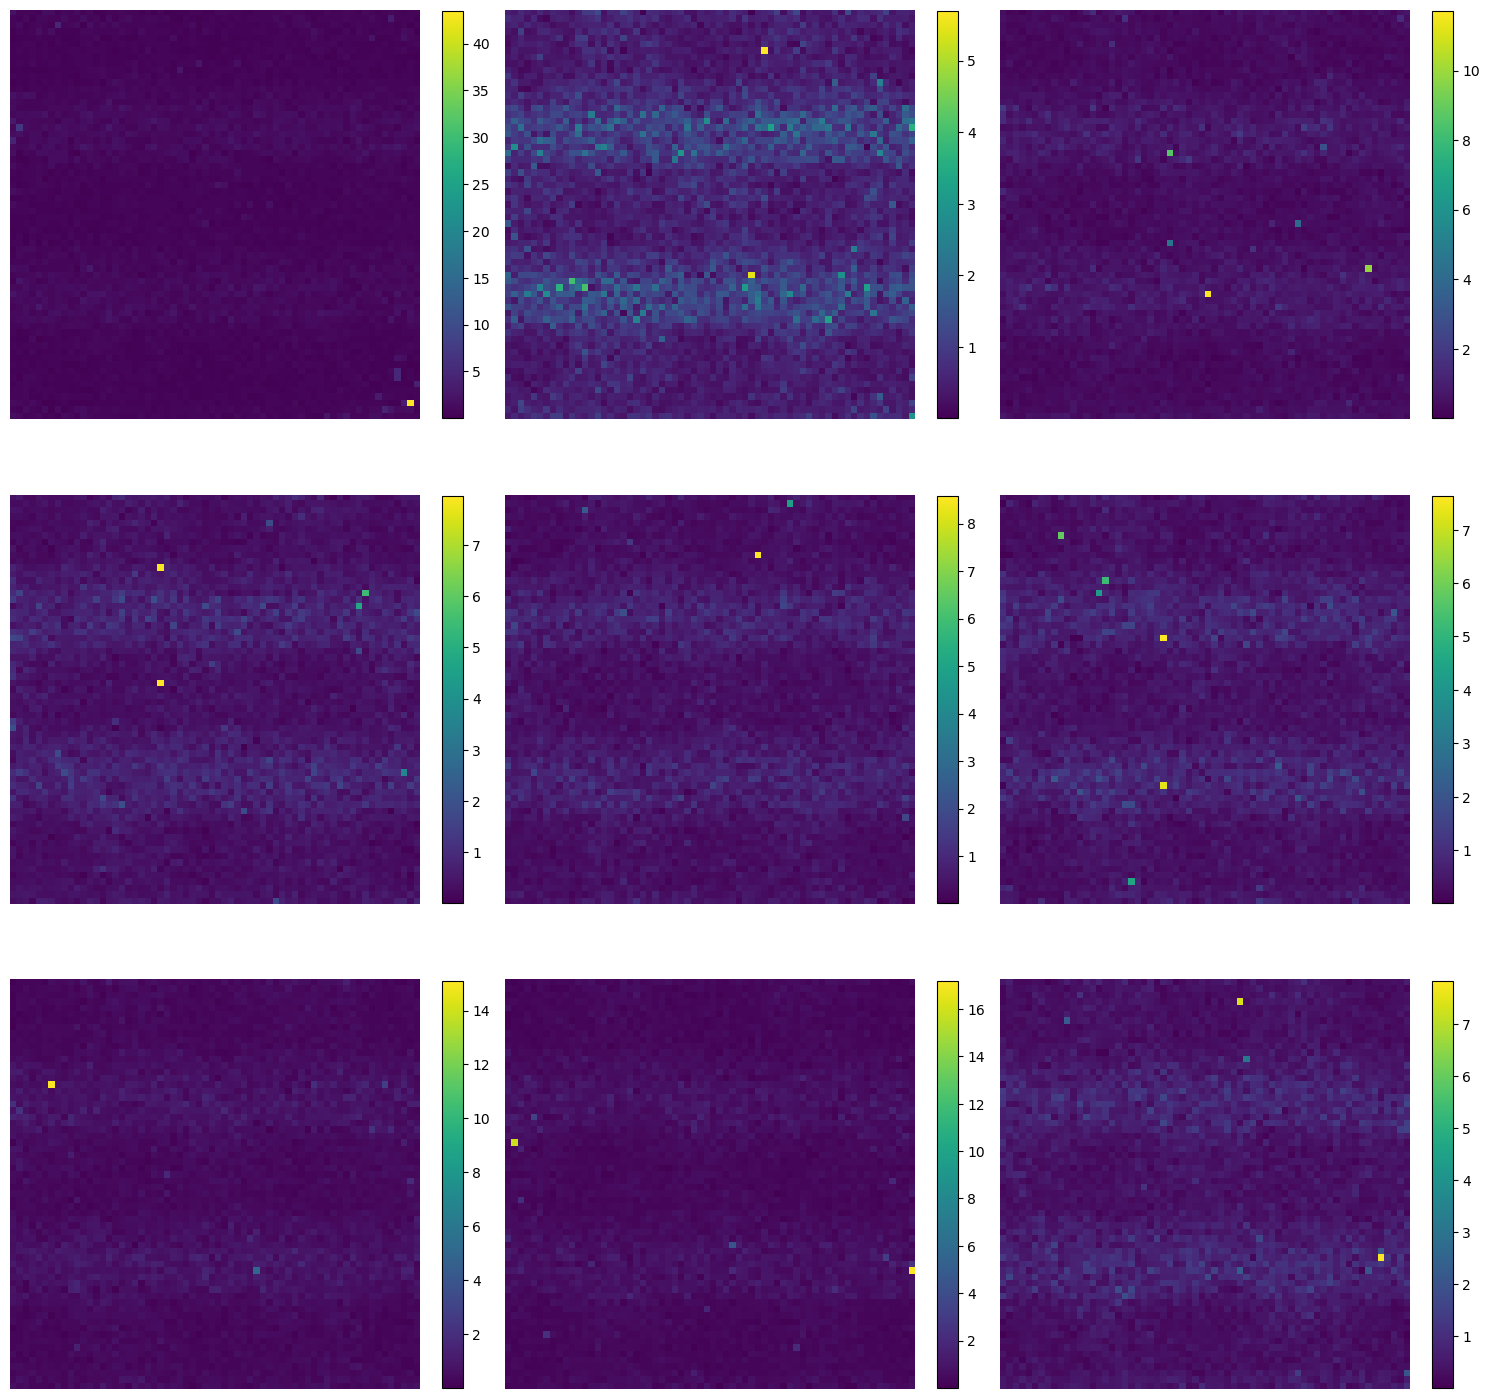

In [ ]:
ns = 3 # ns x ns grid of unit ratemaps
count = 0
fig, ax = plt.subplots(ns,ns, figsize = (15,15))
for i in range(ns):
    for j in range(ns):
        im = ax[i,j].imshow(ratemaps[count])
        ax[i,j].axis("off")
        count += 1
        fig.colorbar(im, fraction = 0.045)
plt.tight_layout()

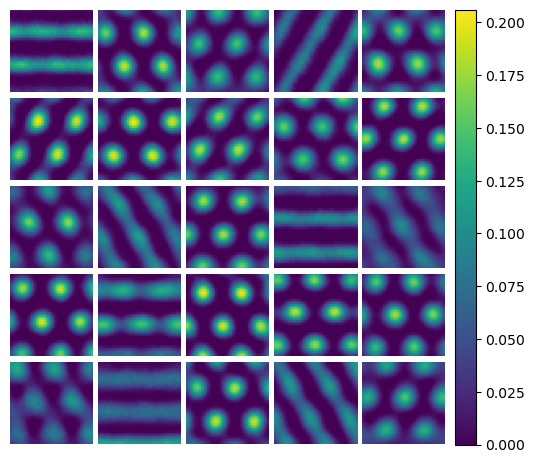

In [ ]:
dataset = DatasetMaker()
rt, vt = dataset.generate_data(10000, 10)

g = model((rt[:,0], vt)).detach().numpy() # double check that states are alright
g_ratemaps = scipy.stats.binned_statistic_2d(rt[...,0].ravel().numpy(), rt[...,1].ravel().numpy(), g.reshape(-1, g.shape[-1]).T, bins = 32)[0]
multiimshow(g_ratemaps[:25], figsize=(5,5));

In [ ]:
sim_losses = np.array([model.similarity_loss(torch.tensor(g[i][None]), torch.tensor(rt[i][None])) for i in range(len(g))])

/var/folders/rv/mky69fln76nbwl7qkb06318h0000gn/T/ipykernel_13562/1513005212.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sim_losses = np.array([model.similarity_loss(torch.tensor(g[i][None]), torch.tensor(rt[i][None])) for i in range(len(g))])


In [ ]:
sim_ratemaps = np.array([scipy.stats.binned_statistic_2d(rt[:,i,0].cpu().numpy(), rt[:,i,1].cpu().numpy(), sim_losses, bins=32)[0] for i in range(timesteps)])

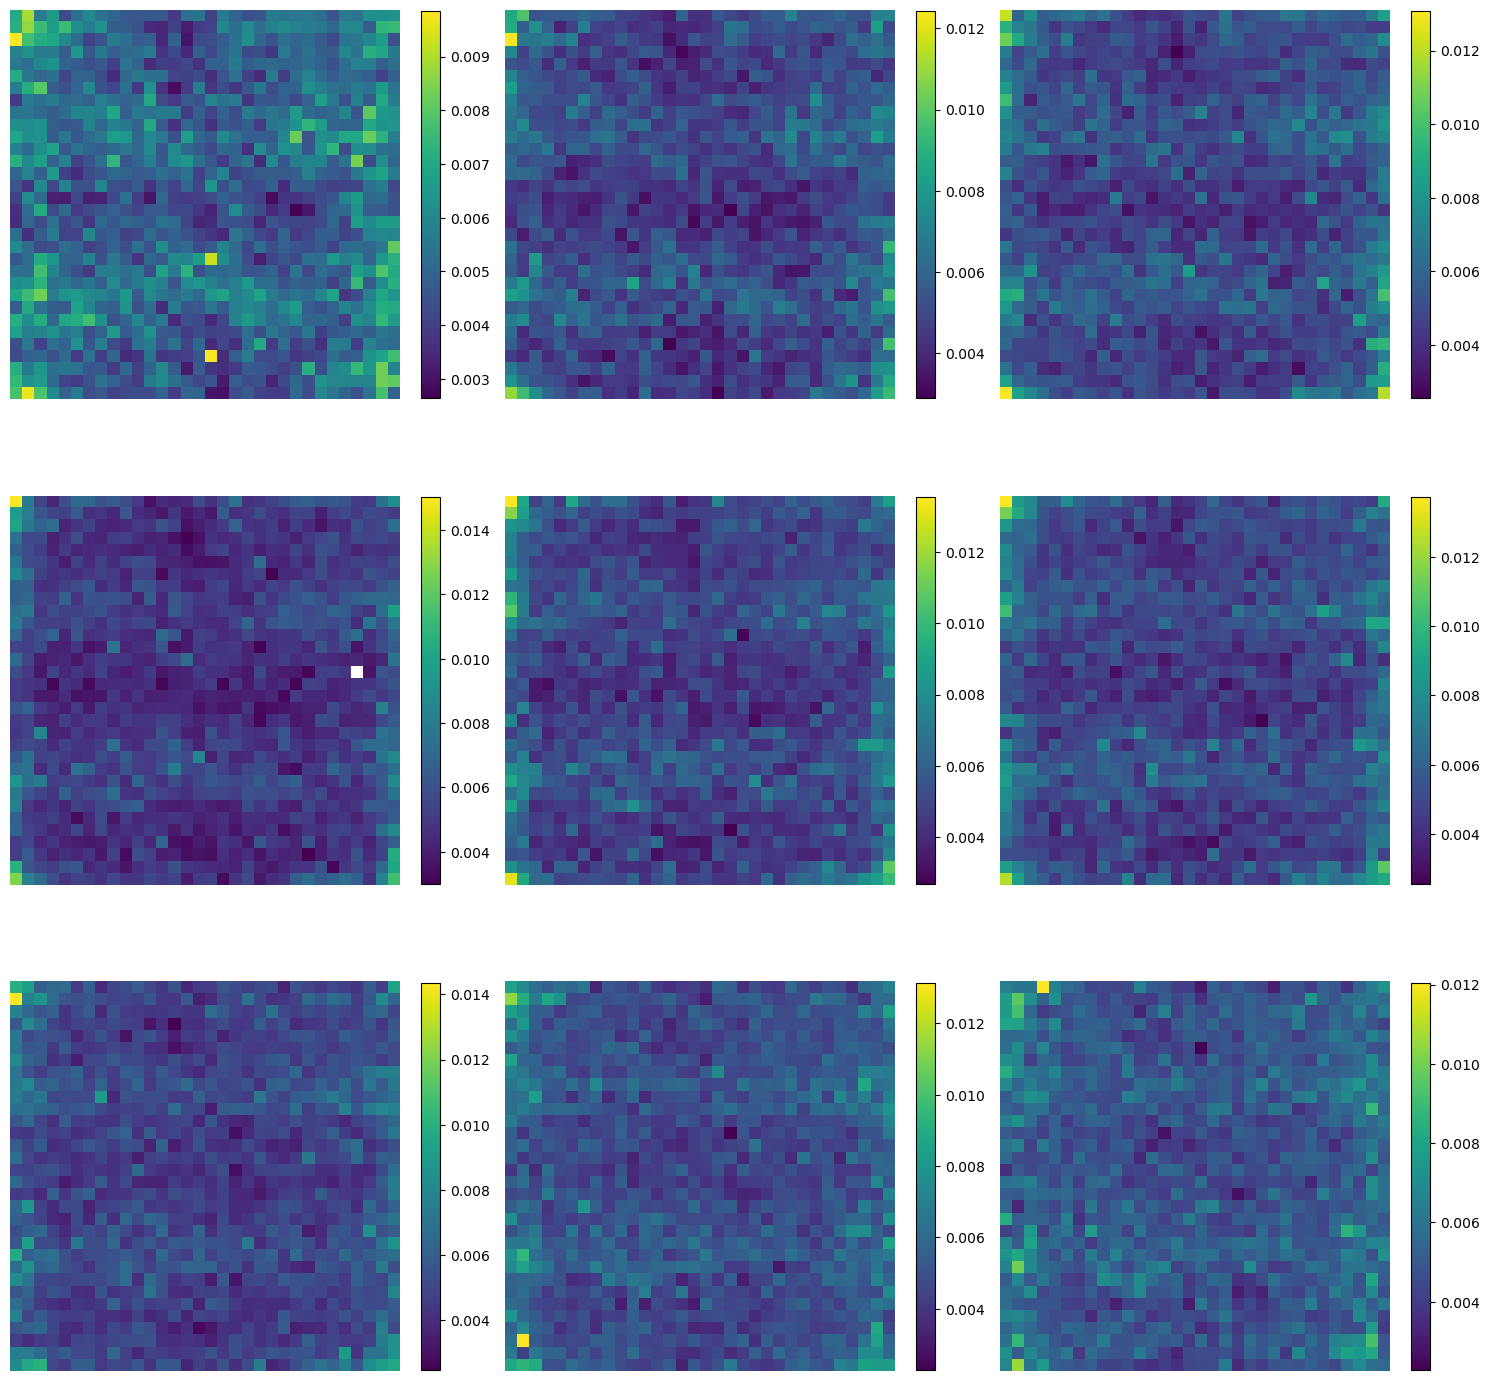

In [ ]:
ns = 3 # ns x ns grid of unit ratemaps
count = 0
fig, ax = plt.subplots(ns,ns, figsize = (15,15))
for i in range(ns):
    for j in range(ns):
        im = ax[i,j].imshow(sim_ratemaps[count])
        ax[i,j].axis("off")
        count += 1
        fig.colorbar(im, fraction = 0.045)
plt.tight_layout()

## FF

In [45]:
model = FFGC()
model = model.load("./best_models/FFGC.pkl")

model.to(device)
pass

torch.Size([16384, 256])


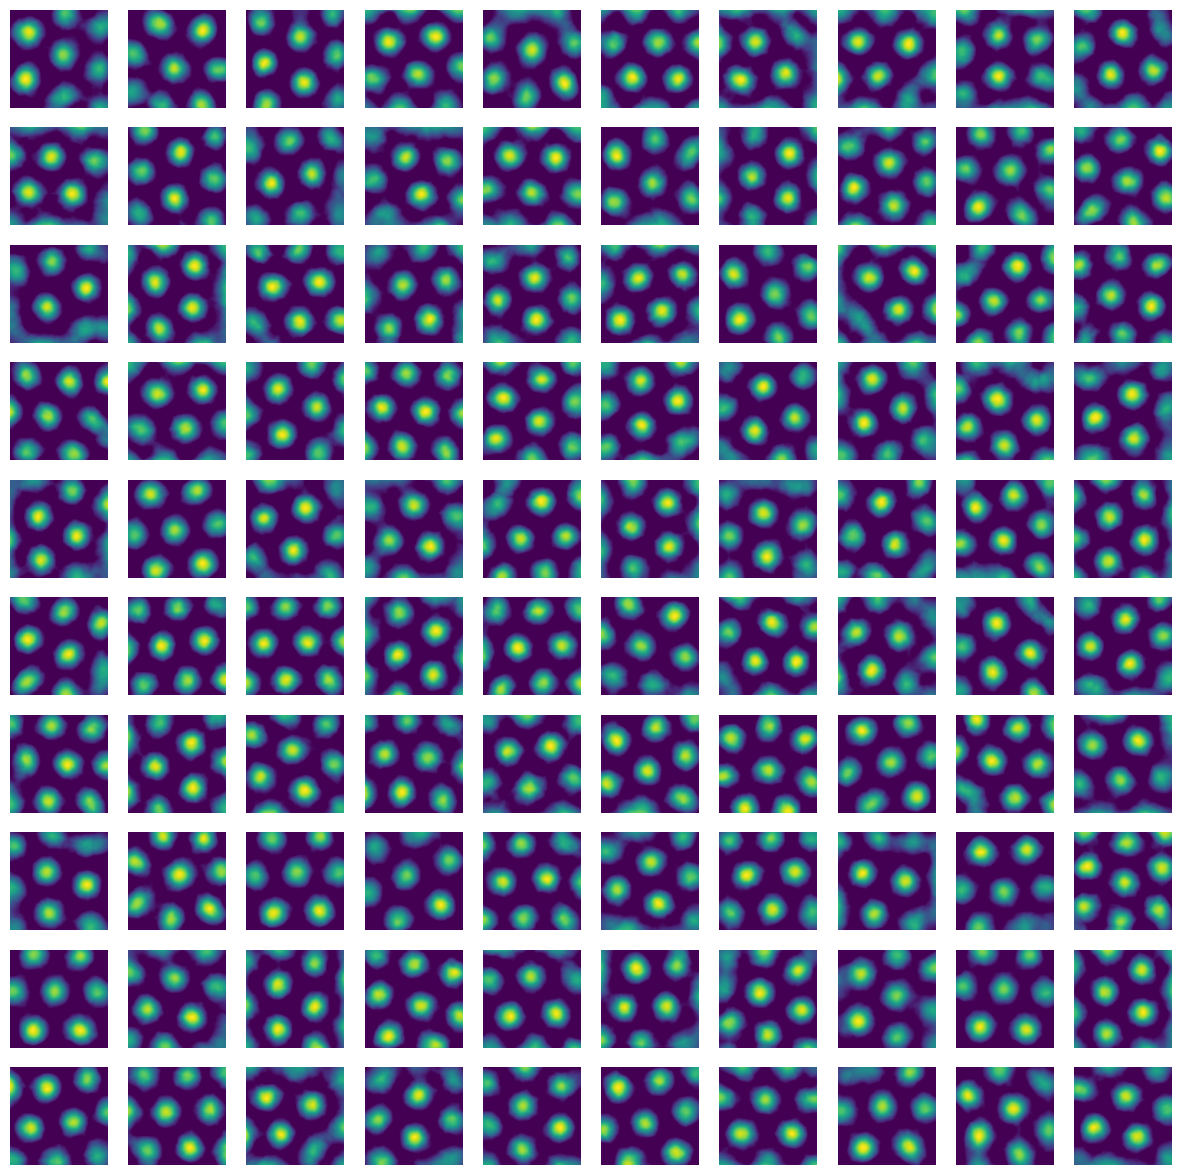

In [46]:
# evaluate on 64x64 grid
bins = 128
x = np.linspace(-1, 1, bins)*2*np.pi
y = np.linspace(-1, 1, bins)*2*np.pi
xx, yy = np.meshgrid(x,y)
r = np.stack([xx.ravel(), yy.ravel()], axis = -1)
gs = model(torch.tensor(r.astype("float32"),device = device))
print(gs.shape)
gs = gs.detach().cpu().numpy()

ns = 10 # ns x ns grid of unit ratemaps
count = 0
fig ,ax = plt.subplots(ns,ns, figsize = (15,15))
for i in range(ns):
    for j in range(ns):
        im = ax[i,j].imshow(gs[...,count].reshape(bins, bins))
        ax[i,j].axis("off")
        count += 1

In [47]:
gs.shape

(16384, 256)

In [48]:
activity = gs.reshape(bins, bins, -1)
activity.shape

(128, 128, 256)

In [ ]:
rescale_r1 = torch.sum(dr1**2, axis=-1)
s1 =  torch.sum((f - f1) ** 2, axis=-1) / torch.maximum(torch.sum(rescale_r1, axis=-1), torch.tensor(1e-14).to(device))
rescale_r2 = torch.sum(dr2**2, axis=-1)
s2 =  torch.sum((f - f2) ** 2, axis=-1) / torch.maximum(torch.sum(rescale_r2, axis=-1), torch.tensor(1e-14).to(device))

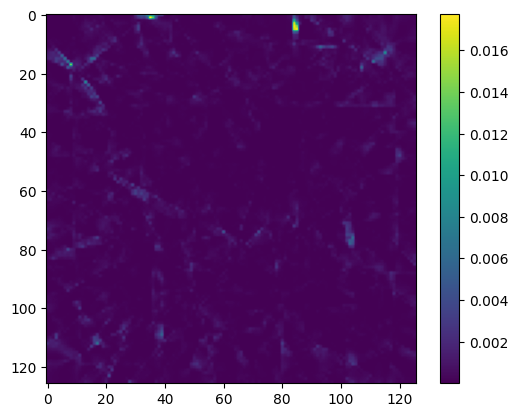

In [61]:
def CI_first_ring(activity, bins, scale = 4*np.pi):
    # Activity of shape: (bins, bins, n_units)
    # Calculate CI on the eight nearest neighbors of each unit, ignoring the corners and edges
    # Scale is the distance per bin in our grid/box
    scaler = scale / bins
    CI_array = np.zeros((bins-2, bins-2))
    for i in range(1,bins-1):
        for j in range(1,bins-1):
            # What bin to consider
            middle = activity[i,j,:]
            # Neighbors on the "plus" direction
            p1 = activity[i-1,j,:]
            p2 = activity[i+1,j,:]
            p3 = activity[i,j-1,:]
            p4 = activity[i,j+1,:]
            r_p = 1*scaler

            # Neighbors on the "cross" direction
            c1 = activity[i-1,j-1,:]
            c2 = activity[i+1,j+1,:]
            c3 = activity[i-1,j+1,:]
            c4 = activity[i+1,j-1,:]
            r_c = np.sqrt(2)*scaler

            s_p1 = np.sum((middle - p1) ** 2) / r_p**2
            s_p2 = np.sum((middle - p2) ** 2) / r_p**2
            s_p3 = np.sum((middle - p3) ** 2) / r_p**2
            s_p4 = np.sum((middle - p4) ** 2) / r_p**2
            s_c1 = np.sum((middle - c1) ** 2) / r_c**2
            s_c2 = np.sum((middle - c2) ** 2) / r_c**2
            s_c3 = np.sum((middle - c3) ** 2) / r_c**2
            s_c4 = np.sum((middle - c4) ** 2) / r_c**2

            ss = np.array([s_p1, s_p2, s_p3, s_p4, s_c1, s_c2, s_c3, s_c4])
            ss = torch.tensor(ss).unsqueeze(-1)

            # Calculate the pairwise distance between each s, need to square to get rid of square root
            ds = torch.pdist(ss, p=2)**2

            CI_loss = torch.mean(ds ** 2)
            CI_array[i-1,j-1] = CI_loss.item()

    return CI_array

CI_array = CI_first_ring(activity, bins)
plt.imshow(CI_array)
plt.colorbar()
plt.show()